### Introduction

We are looking at opening a restaurant but where could we open it? Hence, we explore the different restaurants distribution in two different cities, New York City and Toronto.

### Business Problem

We will need locality information in New York City and Toronto in order to explore opening of a restaurant. We have to ensure good human traffic and there is not many competitors around the area. Hence, we need to analyse different scenarios to increase the success of the restaurants, and to avoid similar restaurants in the same area. The area we should look at are:

- different district school information
- restaurant information

For this project, we are mainly focused on the areas in these two cities to set up a restaurant and ensure maximum profitability for new business.

### Data and Required Libraries

To choose the restaurant, we will need to access following data:

- Neighbourhoods in New York And Toronto
- From the table above, we will use the data to build our analysis. We will use FourSquare APIs for the coordinates data(latitude, longitude) in New York City and Toronto.

From FourSquare, we will need following venues data:

- the school information
- different restaurant information

These data will be used to analysed to determine which location is the best suited to set up the restaurant.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

### Approach

- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Indian Resturants.
- Find rating , tips and like count for each Indian Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Queries that can be answered using above dataset

- What is best location in New York City for Indian Cuisine ?
- Which areas have potential Indian Resturant Market ?
- Which all areas lack Indian Resturants ?
- Which is the best place to stay if I prefer Indian Cuisine ?

### Analysis

In [6]:
pip install geocoder

     |████████████████████████████████| 98 kB 4.2 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install folium

     |████████████████████████████████| 93 kB 1.8 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [10]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [11]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SH2AZ2VA5YT3N5MWIMQ5YUTKDVKL03PAUMRP3QCNUR1U2MFE' # changed my Foursquare ID
    CLIENT_SECRET = 'P3IWZPWOPYHQJY5N3IVEKWHAXLM1JIT3TH4AJKDU4LDVVQNJ' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [12]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'SH2AZ2VA5YT3N5MWIMQ5YUTKDVKL03PAUMRP3QCNUR1U2MFE' # i have changed the id with ##
    CLIENT_SECRET = 'P3IWZPWOPYHQJY5N3IVEKWHAXLM1JIT3TH4AJKDU4LDVVQNJ' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a function to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [13]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [14]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
new_york_data.shape

(306, 4)

There are total of 306 different Neighborhoods in New York

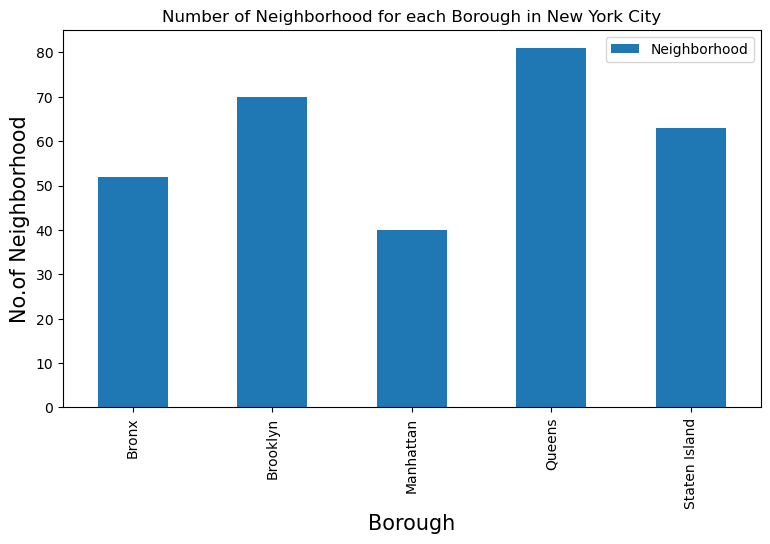

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has highest number of neighborhoods.
Now we will collect Indian resturants for each Neighborhood

In [18]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

With the the Indian restaurants in New York City, the next step is to analyse it.

In [19]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [20]:
indian_rest_ny.shape

(142, 4)

There are 142 Indian Resturants across New York City

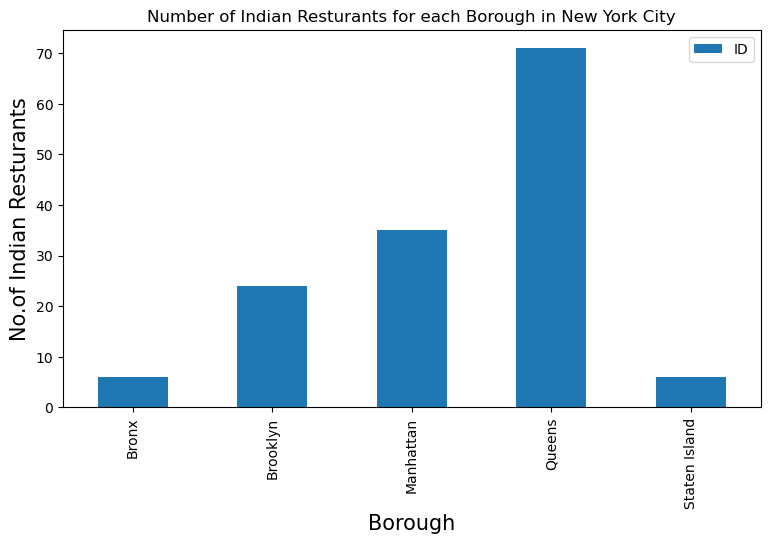

In [21]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has the highest number of Indian Restaurants

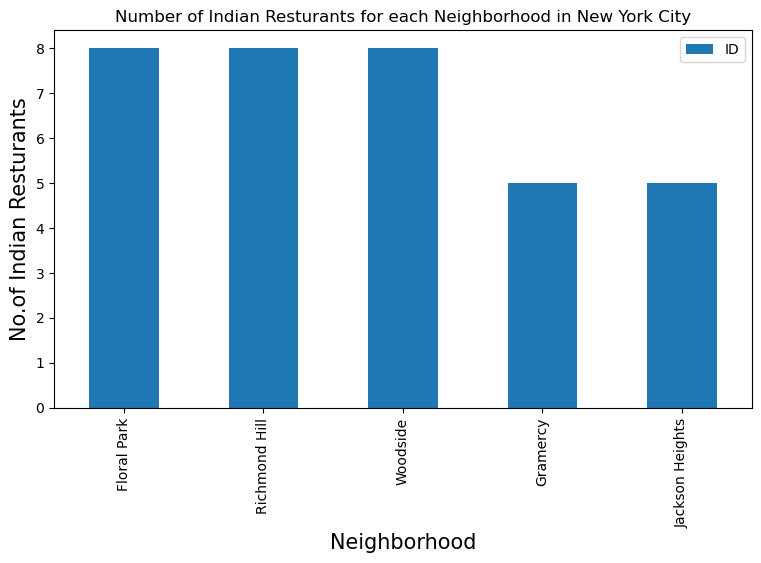

In [22]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [24]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
102,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


Floral Park, Richmond Hill and Woodside in Queens have the highest number of Indian Resturants (8 in each neighbourhood).

Now we will get the ranking of each resturant in Floral Park for further analysis.

In [25]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.7    10
( 1 / 142 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.5     2
( 2 / 142 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 3 / 142 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.0     3
( 4 / 142 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.5     2
( 5 / 142 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     8.3    26
( 6 / 142 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [26]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.5,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.5,2


In [27]:
indian_rest_stats_ny.shape

(50, 7)

In [28]:
indian_rest_ny.shape

(142, 4)

The data obtained for all restaurants will be saved, in an event it is mistakenly modified.


In [29]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [30]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [31]:
indian_rest_stats_ny_csv.shape

(50, 7)

In [32]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.5,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.5,2


In [33]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [34]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [35]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [36]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [37]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                               9.1
Tips                                 150
Name: 41, dtype: object

In [38]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                               9.1
Tips                                 150
Name: 41, dtype: object

In [39]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                424
Rating                               8.7
Tips                                 162
Name: 47, dtype: object

In [42]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [43]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
27,Tribeca,9.100000
13,Greenwich Village,8.900000
31,West Village,8.850000
22,Prospect Lefferts Gardens,8.700000
3,Chelsea,8.700000
12,Gramercy,8.666667
9,Fort Greene,8.600000
29,Upper West Side,8.600000
24,Roosevelt Island,8.400000
19,North Side,8.400000


Above are the top neighborhoods with top average rating of Indian resturants

In [44]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [45]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.296
1,Brooklyn,7.730
0,Bronx,6.700


Above is the average ratings of Indian Restaurants for each Borough.
Visualisation as follows:

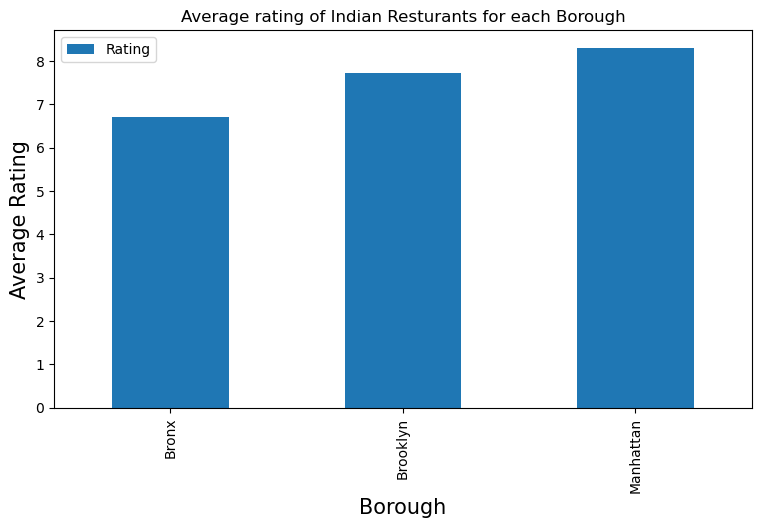

In [46]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Restaurants with average rating greater than or equal to 9.0 wil be visualised on map.

In [48]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [49]:
ny_neighborhood_stats

,Neighborhood,Average Rating
27,Tribeca,9.1


This dataset will be merged with the original New York data to obtain longitude and latitude

In [50]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [51]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [52]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.1


In [54]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


In [55]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [56]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [57]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [66]:
pip install geojson

Note: you may need to restart the kernel to use updated packages.


In [67]:
import geojson

In [85]:
import BoroughBoundaries.geojson

ModuleNotFoundError: No module named 'BoroughBoundaries'

In [98]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'BoroughBoundaries.geojson'

In [99]:
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'BoroughBoundaries.geojson'

### Conclusion

- Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.
- Manhattan have potential for Indian Restaurant Market.
- Staten Island ranks last in average rating of Indian Resturants.
- Manhattan is the best place to stay if you prefer Indian Cuisine.

##    Limitations
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare